In [2]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

# Jelly beans

![jelly](https://imgs.xkcd.com/comics/significant.png)

In [3]:
def test_stat(sample):
    return sum(sample=='Some') / len(sample)

def simulate_once(n_patients):
    acne_levels = make_array('Some', 'None')
    sample = np.random.choice(acne_levels, n_patients, p=make_array(.2, .8))
    return test_stat(sample)

** Null hypothesis:  That 20% of the population has acne, any deviation from this the result of random chance
** Alternative hypothesis:   Eating jelly beans increases acne
** Test statistic:  Proportion of sample that has acne

In [9]:
simulate_once(10)

0.1

In [10]:
n = 1000
nrep = 10000
acne_fractions = make_array()
for i in range(nrep):
    acne_fractions = np.append(acne_fractions, simulate_once(n))
    
acne_fractions

array([0.199, 0.204, 0.191, ..., 0.223, 0.203, 0.209])

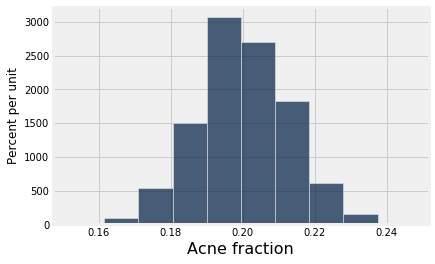

In [11]:
Table().with_column("Acne fraction", acne_fractions).hist()

In [14]:
# for each color jellybean, count fraction of jellybean eaters with acne:
s = "A&W Cream Soda, A&W Root Beer, Berry Blue, Blueberry, Bubble Gum, Buttered Popcorn, Cantaloupe, Cappuccino, Caramel Corn, Chili Mango, Chocolate Pudding, Cinnamon, Coconut, Cotton Candy, Crushed Pineapple, Dr Pepper, French Vanilla, Green Apple, Island Punch, Juicy Pear, Kiwi, Lemon Drop, Lemon Lime, Sunkist Lemon, Licorice, Sunkist Lime, Mango, Margarita, Mixed Berry Smoothie, Orange Sherbet, Sunkist Orange, Peach, Sunkist Pink Grapefruit, Piña Colada, Plum, Pomegranate, Raspberry, Red Apple, Sizzling Cinnamon, Sour Cherry, Strawberry Cheesecake, Strawberry Daiquiri, Strawberry Jam, Sunkist Tangerine, Toasted Marshmallow, Top Banana, Tutti-Fruitti, Very Cherry, Watermelon, Wild Blackberry"
flavors = s.split(",")
# (there are 50 flavors)

for jelly in flavors:
    observed_statistic = simulate_once(1000)

    # and compute the P-value (an approximation based on the simulation)
    pval = sum(acne_fractions>=observed_statistic) / len(acne_fractions)
    if pval < .05:
        print(observed_statistic*100,"% of people eating", jelly, "jelly bean had acne")
        print("P value is", pval)
        print("Publish!", jelly, "flavor jelly causes acne.")
    else:
        continue

23.3 % of people eating  Island Punch jelly bean had acne
P value is 0.006
Publish!  Island Punch flavor jelly causes acne.
22.900000000000002 % of people eating  Red Apple jelly bean had acne
P value is 0.0134
Publish!  Red Apple flavor jelly causes acne.


# Birth months

What month were you born in?

A) Jan-Mar  
B) Apr-Jun  
C) Jul-Sep  
D) Oct-Dec  

In [15]:
birth_month = Table().with_columns(
    "Month", make_array("Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"),
    "Count", make_array(10,14,8,8))
birth_month

Month   | Count
Jan-Mar | 10
Apr-Jun | 14
Jul-Sep | 8
Oct-Dec | 8

** Null hypothesis:  People are born with 25% chance of being in each quarter; any variation is the result of random chance
** Alternative hypothesis:  There is something else going on; not random
** Test statistic: Total variation distance

In [16]:
size_of_class = sum(birth_month.column("Count"))
observed_statistic = sum(abs(birth_month.column("Count")/size_of_class - .25))
observed_statistic

0.19999999999999996

How likely is this distribution of birth months?

In [17]:
random_counts = birth_month.select("Month").sample(size_of_class).group("Month")
random_counts

tvds = make_array()
for i in np.arange(10000): # 10000 repetitions
    random_counts = birth_month.select("Month").sample(size_of_class).group("Month").column("count")
    tvd = sum(abs(random_counts/sum(random_counts) - .25))
    tvds = np.append(tvds, tvd)
    
results = Table().with_column('TVD', tvds)

results

TVD
0.2
0.25
0.15
0.15
0.3
0.1
0.1
0.25
0.15
0.2
... (9990 rows omitted)

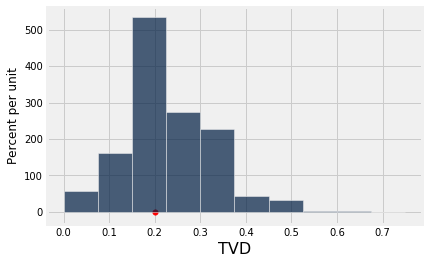

In [18]:
results.hist()

#Plot the observed statistic as a large red point on the horizontal axis
plots.scatter(observed_statistic, 0, color='red', s=30);

In [19]:
results.where('TVD', are.above_or_equal_to(observed_statistic)).num_rows / 10000

0.6473

## Deflategate

In [20]:
football = Table.read_table('football.csv')
football = football.drop('Team')
football.show()

In [21]:
initials = np.append(np.ones(11) * 12.5, np.ones(4) * 13)
halftime_wts = (football.column('Blakeman')+football.column('Prioleau'))/2
football = football.with_columns(
    'Team', np.char.strip(football.column('Ball'), [' 1234567890']),
    'Weight at Halftime', halftime_wts,
    'Estimate at Start', initials,
    'Drop', initials - halftime_wts
)
football.show()

In [22]:
# test statistic
def difference_in_average_drop(t):
    averages = t.select('Team', 'Drop').group('Team', np.average).column(1)
    return averages.item(1) - averages.item(0)

observed = difference_in_average_drop(football)
observed

0.733522727272728

In [23]:
football.select('Drop').show()

In [24]:
shuffled = football.select('Drop').sample(15, with_replacement=False)
football.select('Team').with_column('Drop', shuffled.column(0))

Team     | Drop
Patriots | 0.85
Patriots | 0.425
Patriots | 1.375
Patriots | 1.65
Patriots | 1.175
Patriots | 1.475
Patriots | 1.175
Patriots | 0.275
Patriots | 1.35
Patriots | 1.8
... (5 rows omitted)

In [25]:
sampled_stats = make_array()

for i in np.arange(10000):
    shuffled = football.select('Drop').sample(15, with_replacement=False)
    sample = football.select('Team').with_column('Drop', shuffled.column(0))    
    sampled_stats = np.append(sampled_stats, difference_in_average_drop(sample))

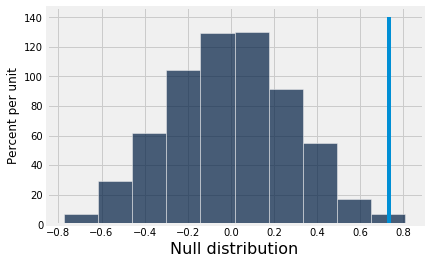

In [26]:
Table().with_column('Null distribution', sampled_stats).hist()
_ = plots.plot([observed, observed], [0, 1.4])

In [27]:
np.count_nonzero(sampled_stats >= observed)/len(sampled_stats)

0.0033